In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import numpy as np
from scipy.stats import chi2_contingency

# read in file info

In [3]:
# read in file to unblind data
df_m5d = pd.read_csv('../data/MARCM_log.txt',sep='\t', header=None)

In [4]:
file_m5d = df_m5d[0]
genotype = df_m5d[1].str.split(pat="/",expand=True)[0]

In [5]:
dict_file_geno = dict(zip(file_m5d,genotype))

# read scoring and unblind samples

In [8]:
df_1 = pd.read_excel('../data/MARCM_scoring/quantification.xlsx', index_col=0).fillna(0)
df_2 = pd.read_excel('../data/MARCM_scoring/quantification_double.xlsx', index_col=0).fillna(0)

In [9]:
df_all = pd.concat([df_1, df_2], axis=1)

In [10]:
df_all = df_all.reset_index().dropna().set_index('index')

In [11]:
# add duplicated columns to dict(brain with clone on both sides)
dict_file_geno['424bb838468bc1aa18f1d749e65b382d.1'] = dict_file_geno['424bb838468bc1aa18f1d749e65b382d']
dict_file_geno['3ec4fea87047a10e7c9c6a73b2135b6f.1'] = dict_file_geno['3ec4fea87047a10e7c9c6a73b2135b6f']
dict_file_geno['ca2772f87b5e7d6b1b7976c702191e4a.1'] = dict_file_geno['ca2772f87b5e7d6b1b7976c702191e4a']
dict_file_geno['f58e2f0e498ec6e4de2216469cbc8a97.1'] = dict_file_geno['f58e2f0e498ec6e4de2216469cbc8a97']
dict_file_geno['f78425cdc72dbb1abf55bd5d8b7faf73.1'] = dict_file_geno['f78425cdc72dbb1abf55bd5d8b7faf73']
dict_file_geno['0fdc3d2c51dd6596b19d9a682d7be5a8_2'] = dict_file_geno['0fdc3d2c51dd6596b19d9a682d7be5a8']
dict_file_geno['ea97a5fd0bf4d877eda7669dadf8ccb5_2'] = dict_file_geno['ea97a5fd0bf4d877eda7669dadf8ccb5']

In [12]:
dict_file_geno['01f8fcad93bde45e82c5f082f87a8fb7_2'] = dict_file_geno['01f8fcad93bde45e82c5f082f87a8fb7']
dict_file_geno['12168274418cadba161aa22156791985_2'] = dict_file_geno['12168274418cadba161aa22156791985']
dict_file_geno['c4197a98e8393e6ae344e44876a56a33_2'] = dict_file_geno['c4197a98e8393e6ae344e44876a56a33']
dict_file_geno['e2cf1d0f44c7b24aa0872b1c8a555905_2'] = dict_file_geno['e2cf1d0f44c7b24aa0872b1c8a555905']
dict_file_geno['fed38e34d2ba225563c318ef0b370d31_2'] = dict_file_geno['fed38e34d2ba225563c318ef0b370d31']


In [13]:
genotype = pd.Series(dict(zip(df_all.columns, [dict_file_geno[file] for file in df_all.columns])), name='genotype')

In [14]:
df_all = df_all.append(genotype).T

In [16]:
glomeruli = df_all.columns[:-1]

# find significantly changed glomeruli

In [17]:
def get_glo_freq(df_curr, glomeruli):
    """
    input: dataframe of a current genotype; row: antenna lobe; col: glomeruli names
    output: frequency table of innervation pattern for each glomeruli;
            row: glomeruli names; col: frequency
    """
    freq = pd.DataFrame(columns=np.arange(0,3), index=df_curr.columns)
    for glom in glomeruli:
        curr_freq = np.unique(df_curr[glom], return_counts=True)
        freq.loc[glom][curr_freq[0]] = curr_freq[1]
        
    return freq.fillna(0)

In [18]:
genotype.value_counts()

acj66+UAS-otk              34
acj66+UAS-DopR             26
acj66+UAS-Dop2R            25
acj66+UAS-piezo            24
acj66+UAS-Dg+UAS-piezo     22
control                    21
acj66+UAS-CG5027           21
acj66+UAS-Dg               20
acj66+UAS-Ost              20
acj66+UAS-otk+UAS-piezo    20
acj66                      20
acj66+UAS-otk+UAS-Dg       19
acj66+UAS-Nep3             19
acj66+UAS-Dg+UAS-Nep3      17
acj66+UAS-DopR+UAS-otk     13
acj66+UAS-Dg+UAS-Dop2R     12
acj66+UAS-Dop2R+UAS-otk    12
acj66+UAS-ost+UAS-otk      11
acj66+UAS-acj6             10
Name: genotype, dtype: int64

In [19]:
df_wt = df_all.loc[df_all['genotype'] == 'control'].drop('genotype', 1)
freq_wt = get_glo_freq(df_wt, glomeruli)

In [20]:
def get_average_score(glo_geno_freq):
    total = glo_geno_freq.sum()
    average = (glo_geno_freq[1] + glo_geno_freq[2]*2)/total
    
    return average

In [21]:
df_acj66 = df_all.loc[df_all['genotype'] == 'acj66'].drop('genotype', 1)
freq_acj66 = get_glo_freq(df_acj66, glomeruli)

In [22]:
chi_square = pd.DataFrame(columns=list(glomeruli), index=genotype.unique(), dtype=int)
for curr_geno in genotype:
    # get innervation pattern for curr glomerulus
    df_curr = df_all.loc[df_all['genotype'] == curr_geno].drop('genotype', 1)
    freq_curr = get_glo_freq(df_curr, glomeruli)  
    for glom in glomeruli:
        # calculate p-value compared to wt control and acj6 mutant
        c_table = np.array([freq_wt.loc[glom],freq_curr.loc[glom]])
        c_table = c_table[:,(c_table[0] + c_table[1]) != 0]
        c_table_acj6 = np.array([freq_acj66.loc[glom],freq_curr.loc[glom]])
        c_table_acj6 = c_table_acj6[:,(c_table_acj6[0] + c_table_acj6[1]) != 0]
        p_value_ctrl = chi2_contingency(c_table)[1]
        p_value_acj6 = chi2_contingency(c_table_acj6)[1]
        if p_value_ctrl > 0.05: score = 0
        else:
            # compare the innervation degree
            mean_wt = get_average_score(freq_wt.loc[glom])
            mean_curr = get_average_score(freq_curr.loc[glom])
            mean_acj66 = get_average_score(freq_acj66.loc[glom])
            # check if value is 
            if mean_curr > mean_wt:
                if (mean_curr < mean_acj66) and (p_value_acj6 < 0.05): score = 1
                else: score = 2
            else:
                if (mean_curr > mean_acj66) and (p_value_acj6 < 0.05): score = -1
                else: score = -2
                    
        chi_square.loc[curr_geno, glom] = score

In [23]:
new_order = ['control', 'acj66', 'acj66+UAS-acj6', 'acj66+UAS-otk', 'acj66+UAS-piezo', 'acj66+UAS-Dg',
             'acj66+UAS-Nep3', 'acj66+UAS-Ost', 'acj66+UAS-CG5027', 'acj66+UAS-Dop2R', 'acj66+UAS-DopR',
             'acj66+UAS-Dg+UAS-piezo', 'acj66+UAS-Dg+UAS-Nep3', 'acj66+UAS-Dg+UAS-Dop2R',
             'acj66+UAS-otk+UAS-Dg', 'acj66+UAS-otk+UAS-piezo', 'acj66+UAS-DopR+UAS-otk',
             'acj66+UAS-Dop2R+UAS-otk', 'acj66+UAS-ost+UAS-otk']

In [24]:
chi_square = chi_square.reindex(new_order)

In [25]:
camp_select = ['#6180ff', '#b1c0fc','#f0f0f0','#fca8a4','#f73d34']

In [26]:
glomeruli_selected = ['DA3','VA3','VM7','VM2','VA1v',
                        'VA6','DA4m','VL2a','DL2','VM5v','DA2']

In [27]:
new_order = ['control', 'acj66', 'acj66+UAS-acj6', 'acj66+UAS-otk', 'acj66+UAS-piezo', 'acj66+UAS-Dg',
             'acj66+UAS-DopR', 'acj66+UAS-Dop2R',
             'acj66+UAS-Nep3', 'acj66+UAS-CG5027', 'acj66+UAS-Ost', 'blank',
             'acj66+UAS-otk+UAS-Dg', 'acj66+UAS-otk+UAS-piezo', 'acj66+UAS-DopR+UAS-otk', 'acj66+UAS-Dop2R+UAS-otk', 
             'acj66+UAS-Dg+UAS-piezo', 'acj66+UAS-Dg+UAS-Dop2R', 'acj66+UAS-Dg+UAS-Nep3']

In [28]:
x = chi_square.reindex(new_order)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0.5, 1, 'DA3'),
  Text(1.5, 1, 'VA3'),
  Text(2.5, 1, 'VM7'),
  Text(3.5, 1, 'VM2'),
  Text(4.5, 1, 'VA1v'),
  Text(5.5, 1, 'VA6'),
  Text(6.5, 1, 'DA4m'),
  Text(7.5, 1, 'VL2a'),
  Text(8.5, 1, 'DL2'),
  Text(9.5, 1, 'VM5v'),
  Text(10.5, 1, 'DA2')])

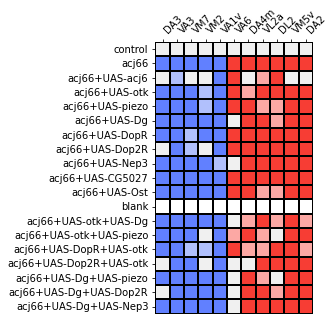

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(x[glomeruli_selected], cmap=camp_select, cbar=False, square=True,
            linewidths=0.2, linecolor='k')
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=45, ha='left')
# fig.savefig('../figure/MARCM/p_value/only_sig.pdf', bbox_inches='tight')

# generate double stacked bar graph for all 

In [30]:
new_order = ['control', 'acj66', 'acj66+UAS-acj6', 'acj66+UAS-otk', 'acj66+UAS-piezo', 'acj66+UAS-Dg',
             'acj66+UAS-DopR', 'acj66+UAS-Dop2R',
             'acj66+UAS-Nep3', 'acj66+UAS-CG5027', 'acj66+UAS-Ost',
             'acj66+UAS-otk+UAS-Dg', 'acj66+UAS-otk+UAS-piezo', 'acj66+UAS-DopR+UAS-otk', 'acj66+UAS-Dop2R+UAS-otk', 
             'acj66+UAS-Dg+UAS-piezo', 'acj66+UAS-Dg+UAS-Dop2R', 'acj66+UAS-Dg+UAS-Nep3']

In [31]:
pd_freq = pd.DataFrame(columns=['genotype','glomerulus','none','weak','strong','total'])
for curr_geno in new_order:
    for curr_glo in df_all.columns[:-1]:
        counts = df_all[df_all.genotype == curr_geno][curr_glo].value_counts().sort_index()
        if 0 not in counts:
            none = 0
        else:
            none = counts[0]
        if 1 not in counts:
            weak = 0
        else:
            weak = counts[1]
        if 2 not in counts:
            strong = 0
        else:
            strong = counts[2]         
        pd_freq = pd_freq.append({'genotype':curr_geno, 'glomerulus':curr_glo,'none':none,
                                  'weak':weak,'strong':strong,'total':none+weak+strong},ignore_index=True)

In [32]:
pd_freq['genotype'] = pd_freq['genotype'].astype('category')
pd_freq.genotype.cat.reorder_categories(new_order, inplace=True)
pd_freq.sort_values('genotype', inplace=True)

In [33]:
def get_glo_freq_percent(glomerulus, genotype, pd_freq):
    pd_curr = pd_freq[(pd_freq['glomerulus'] == glomerulus) & (pd_freq['genotype'].isin(genotype))]
    pd_glo_freq = pd.DataFrame({'genotype':pd_curr['genotype'],
                                'none':pd_curr['none']/pd_curr['total']*100,
                                'weak':pd_curr['weak']/pd_curr['total']*100,
                                'strong':pd_curr['strong']/pd_curr['total']*100})
    return pd_glo_freq

In [34]:
glomerulus = 'VL2a'
plot_freq = get_glo_freq_percent(glomerulus,genotype, pd_freq)

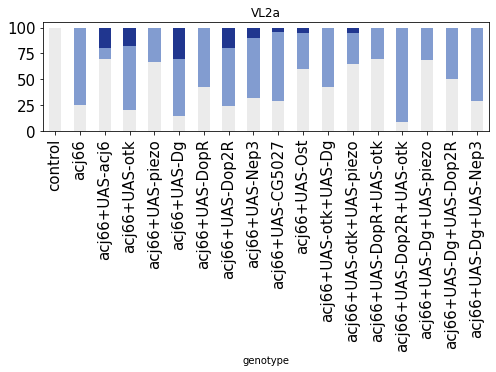

In [35]:
ax = plot_freq.plot(x = 'genotype', kind = 'bar', stacked = True, 
                    color={"none": "#EBEBEB", "weak": "#829CD0",'strong':'#20368F'},
                    title = glomerulus, fontsize=15, legend=False, figsize=(8, 2)) 

In [36]:
df_all.genotype.value_counts()

acj66+UAS-otk              34
acj66+UAS-DopR             26
acj66+UAS-Dop2R            25
acj66+UAS-piezo            24
acj66+UAS-Dg+UAS-piezo     22
control                    21
acj66+UAS-CG5027           21
acj66+UAS-Dg               20
acj66+UAS-Ost              20
acj66+UAS-otk+UAS-piezo    20
acj66                      20
acj66+UAS-otk+UAS-Dg       19
acj66+UAS-Nep3             19
acj66+UAS-Dg+UAS-Nep3      17
acj66+UAS-DopR+UAS-otk     13
acj66+UAS-Dg+UAS-Dop2R     12
acj66+UAS-Dop2R+UAS-otk    12
acj66+UAS-ost+UAS-otk      11
acj66+UAS-acj6             10
Name: genotype, dtype: int64

In [37]:
all_glomeruli = chi_square.columns

In [38]:
def plot_bars(pd_freq, all_glomeruli):
    fig, axes = plt.subplots(len(all_glomeruli), 1, figsize=(15,2*len(all_glomeruli)), sharex=True)
    i = 0
    for glomerulus in all_glomeruli:
        plot_freq = get_glo_freq_percent(glomerulus,genotype, pd_freq)
        plot_freq.plot(x = 'genotype', kind = 'bar', stacked = True, ax=axes[i],
                            color={"none": "#EBEBEB", "weak": "#829CD0",'strong':'#20368F'},
                            title = glomerulus, fontsize=15, legend=False)
        axes[i].set_xlabel("")
        axes[i].set_title('')
        axes[i].set_ylabel(glomerulus, fontsize=18)
        i += 1
    return fig, axes

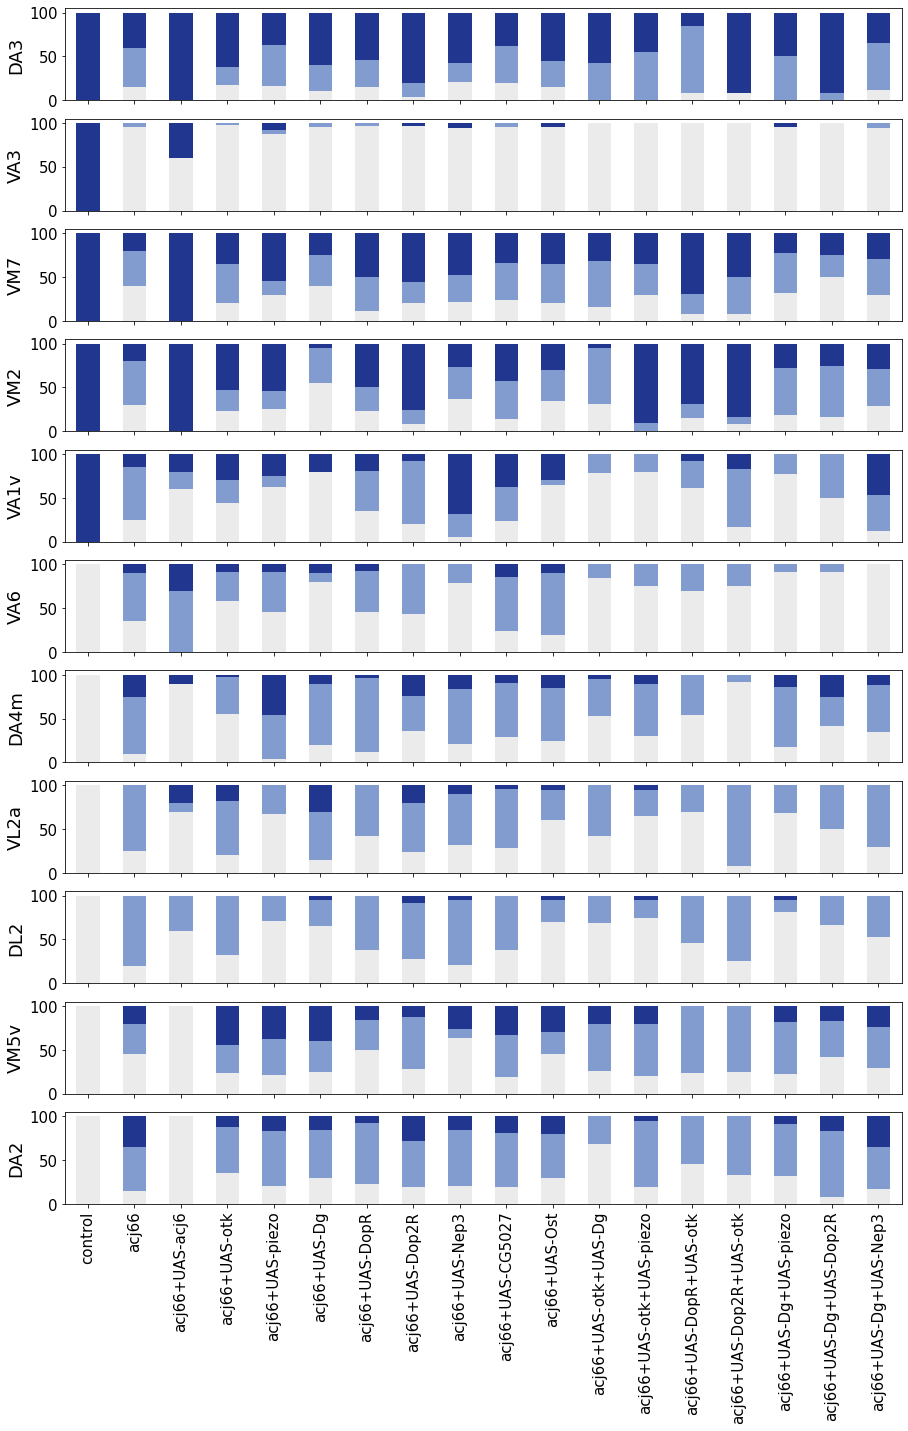

In [39]:
fig, axes = plot_bars(pd_freq, glomeruli_selected)

In [40]:
fig.savefig('../figure/MARCM/stacked_bar/selected', bbox_inches='tight')

In [41]:
from matplotlib import colors

In [42]:
cmap_dict = colors.ListedColormap(['#6180ff', '#b1c0fc','#f0f0f0','#fca8a4','#f73d34'])

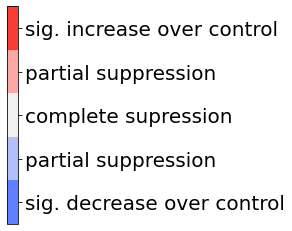

In [43]:
s = plt.imshow(chi_square, cmap=cmap_dict)
plt.gca().set_visible(False)
cbar = plt.colorbar(s)
cbar.set_ticks(np.arange(-1.6, 2, 0.8))
cbar.ax.tick_params(labelsize=20) 
cbar.set_ticklabels(["sig. decrease over control", "partial suppression", "complete supression", 
                     "partial suppression", "sig. increase over control"])
cbar = fig.colorbar(mappable=s, ax=ax)

# plt.savefig('../figure/MARCM/p_value/color_bar_2.pdf', bbox_inches='tight')